# S82 QSO lightcurves (9258) from MacLeod et al 2011 Catalog
spectroscopically confirmed QSOs in the SDSS DR7 stripe 82 (22h 24m < R.A. < 04h 08m and | Dec | < 1.27 deg, about 290 deg2)
http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern.html

In [2]:
import pdb
import os as os
import random
import pickle
import pandas as pd
import numpy as np
import math

#KALI for stochatic modelling
#import kali.s82
import kali.carma
import kali.util.mcmcviz as mcmcviz
from kali.util.mpl_settings import set_plot_params
import kali.util.triangle as triangle
import kali.csvLC


#Plotting 
import matplotlib.pyplot as plt
import matplotlib
#import richardsplot as rplot
%matplotlib inline

# Previewing Files

In [3]:
import glob 
lcs = glob.glob("../lightcurves/*")

In [4]:
names = ['MJD_u','u','u_err','MJD_g','g','g_err',
        'MJD_r','r','r_err','MJD_i','i','i_err',
        'MJD_z','z','z_err','ra_median','decl_median']
test = pd.read_csv(lcs[0], delimiter = ' ',names=names)
test[:10]

,MJD_u,u,u_err,MJD_g,g,g_err,MJD_r,r,r_err,MJD_i,i,i_err,MJD_z,z,z_err,ra_median,decl_median
0,51075.367187,20.883,0.074,51075.368853,20.985,0.032,51075.365520,20.547,0.031,51075.366353,20.552,0.050,51075.368020,20.536,0.244,24.307223,0.28012
1,52170.387853,20.988,0.086,52170.389519,21.082,0.033,52170.386186,20.656,0.032,52170.387019,20.618,0.045,52170.388686,20.513,0.190,24.307223,0.28012
2,52196.386450,21.010,0.113,52196.388116,20.975,0.037,52196.384783,20.619,0.038,52196.385616,20.638,0.059,52196.387283,20.349,0.214,24.307223,0.28012
3,52207.353148,20.916,0.092,52207.354814,20.946,0.033,52207.351481,20.514,0.032,52207.352314,20.544,0.044,52207.353981,20.782,0.234,24.307223,0.28012
4,52224.281342,20.936,0.085,52224.283008,20.819,0.027,52224.279675,20.544,0.029,52224.280508,20.510,0.038,52224.282175,20.522,0.163,24.307223,0.28012
5,52231.266772,20.695,0.075,52231.268438,20.736,0.029,52231.265105,20.522,0.030,52231.265938,20.418,0.037,52231.267605,20.760,0.244,24.307223,0.28012
6,52234.237861,20.640,0.072,52234.239527,20.769,0.027,52234.236194,20.437,0.028,52234.237027,20.492,0.039,52234.238694,20.688,0.190,24.307223,0.28012
7,52261.201216,20.534,0.076,52261.202882,20.582,0.025,52261.199549,20.392,0.034,52261.200382,20.306,0.043,52261.202049,20.368,0.177,24.307223,0.28012
8,52282.127845,-99.990,0.072,52282.129511,20.623,0.029,52282.126178,20.354,0.032,52282.127011,20.283,0.042,52282.128678,20.541,0.217,24.307223,0.28012
9,52287.081709,20.501,0.063,52287.083375,20.573,0.027,52287.080042,20.331,0.032,52287.080875,20.159,0.035,52287.082542,20.301,0.169,24.307223,0.28012


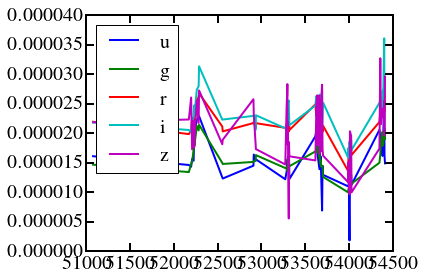

In [5]:
@np.vectorize
def luptitude_to_flux(mag, err, band):  # Converts a Luptitude to an SDSS flux
    b_ = dict(u=1.4e-10, g=0.9e-10, r=1.2e-10, i=1.8e-10, z=7.4e-10)
    f0 = 3631.0  # Jy
    flux = math.sinh(math.log(10.0)/-2.5*mag-math.log(b_[band]))*2*b_[band]*f0
    error = err*math.log(10)/2.5*2*b_[band]*math.sqrt(1+(flux/(2*b_[band]*f0))**2)*f0
    return flux, error

def previewBands(test, labels = False):
    bands = ['u','g','r','i','z']
    for c, v in enumerate(bands):
        mask = (test[v] > -99) & (test[v+'_err'] < 99)
        flux, error = luptitude_to_flux(test[v][mask], test[v+'_err'][mask], v)
        f = plt.plot(test['MJD_'+v][mask], flux, label = v)
        if labels == True:
            plt.legend(loc = 'best')
        plt.tight_layout()
 
previewBands(test, labels = True)

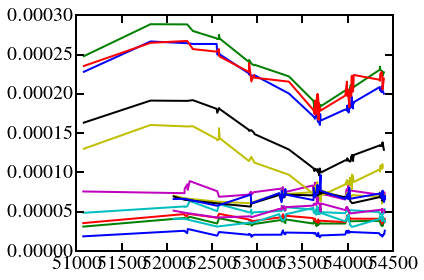

In [6]:
random = np.random.choice(len(lcs),3)

for c, value in enumerate(random):
    test = pd.read_csv(lcs[value], delimiter = ' ',names=names)
    previewBands(test)                      

# Previewing DRW results from MacLeod 2011

In [117]:
band = 'r'
columns = ['SDR5ID', 'ra', 'dec', 'redshift', 'M_i', 'mass_BH', 'chi2_pdf', 'log10tau', 
           'log10sigma', 'log10tau_lim_lo', 'log10tau_lim_hi',
           'log10sig_lim_lo', 'log10sig_lim_hi', 
           'edge_flag' ,'Plike',
           'Pnoise' , 'Pinf' , 'mu' , 'npts']
data = np.loadtxt('../s82drw/s82drw_'+ str(band)+'.dat',skiprows=3)
drwDB = pd.DataFrame(data, columns = columns)
#drwDB.SDR5ID = drwDB.SDR5ID.astype(int)

In [111]:
drwDB

,SDR5ID,ra,dec,redshift,M_i,mass_BH[M/M_sun],chi^2_pdf,log10(tau [days]),log10(sigma [mag/sqrt(yr)],log10(tau_lim_lo),log10(tau_lim_hi),log10(sig_lim_lo),log10(sig_lim_hi),edge_flag,Plike,Pnoise,Pinf,mu,npts
0,301.0,2.169302,1.238649,1.0730,-23.901,0.000,1.192600,1.901620,-0.686379,1.703160,3.081360,-0.957464,-0.627884,0.0,138.9260,117.2180,136.0730,20.2857,60.0
1,144.0,1.091028,0.962126,0.7867,-23.399,0.000,1.278570,2.729090,-0.717700,2.618300,4.472480,-0.840168,-0.660262,0.0,123.0920,75.9121,122.5240,19.8702,52.0
2,58.0,0.331289,0.177230,1.6199,-24.735,0.000,1.194070,2.440220,-0.848145,2.244340,4.120200,-1.022690,-0.781607,0.0,134.3600,107.7100,132.8650,20.3141,57.0
3,190.0,1.364696,-0.098956,0.6125,-23.121,0.000,1.124260,2.872940,-0.627733,2.729950,4.499240,-0.719803,-0.591494,0.0,152.5930,82.2158,152.0940,19.4742,62.0
4,36.0,0.221552,-0.292485,2.7563,-26.451,9.361,0.896713,2.535320,-1.155490,2.337300,4.252470,-1.323420,-1.076520,0.0,167.7060,147.0800,166.5630,19.5994,56.0
5,49.0,0.281370,0.686984,1.3988,-24.917,8.817,0.870333,2.530100,-0.832748,2.395300,4.216270,-0.940410,-0.795638,0.0,175.0300,103.2010,173.6500,19.7200,63.0
6,370.0,2.607954,0.913245,2.8473,-27.263,0.000,1.115170,5.000000,-1.325000,3.438920,4.719630,-1.410870,-1.219870,1.0,165.1110,106.7720,165.1100,18.9610,52.0
7,229.0,1.669492,0.643952,1.3383,-24.427,8.666,0.987443,2.346900,-0.714265,2.190970,3.984700,-0.839718,-0.670921,0.0,149.4630,99.1290,147.6760,20.0716,61.0
8,699.0,4.850273,-0.276395,1.7690,-25.251,0.000,1.075420,2.900370,-0.789369,2.758140,4.492600,-0.908632,-0.723503,0.0,115.5100,74.7377,114.9290,20.2314,51.0
9,578.0,4.026021,0.478127,1.8725,-24.999,0.000,1.054180,2.789950,-0.810464,2.647280,4.527900,-0.953375,-0.752173,0.0,113.8470,84.8468,113.5660,20.5042,53.0


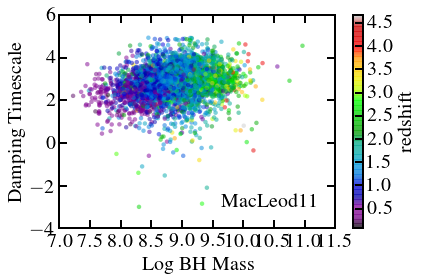

In [131]:
mask999 = (drwDB.mass_BH >0)&(drwDB.log10tau <5) & (drwDB.log10tau >-5)
plt.scatter(drwDB.mass_BH[mask999], drwDB.log10tau[mask999] ,c = drwDB.redshift[mask999], 
            cmap = 'nipy_spectral', alpha = 0.5, linewidth = 0, label = 'MacLeod11')
plt.colorbar(label = 'redshift')
plt.xlabel('Log BH Mass')
plt.ylabel('Damping Timescale')
plt.legend(loc='lower right',frameon=False,markerscale=0)
plt.tight_layout()